In [1]:
%matplotlib inline
import sys
sys.path.append('/home/ubuntu/tools/python-genomics')
import Scanpyplus
import scanpy as sc
import anndata
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
plt.show()
matplotlib.rcParams.update({'figure.figsize': (8,8)})

# This notebook shows how to integrate datasets with strong batch effect without doing correction

##### Run default processing (required to generate embedding and colors)

In [2]:
adata_all = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')

/home/ubuntu/miniconda3/envs/flng/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ubuntu/miniconda3/envs/flng/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
adata=Scanpyplus.GetRaw(adata_all)

In [4]:
adata

AnnData object with n_obs × n_vars = 14693 × 24516
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    obsm: 'X_pca', 'X_umap'

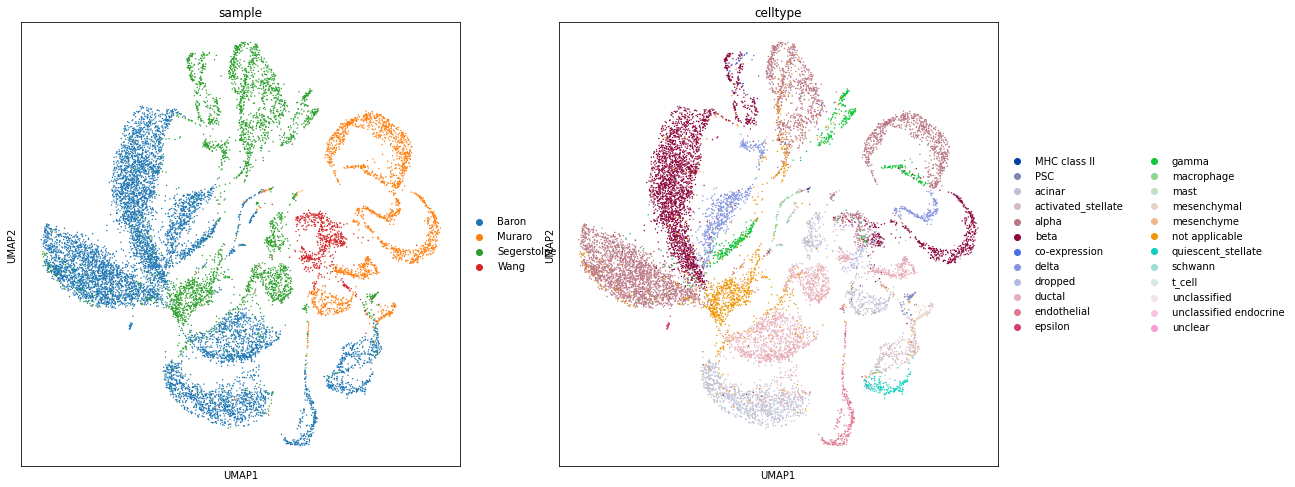

In [5]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw=adata
adata=adata[:,adata.var['highly_variable']]
sc.pp.regress_out(adata,keys='n_counts')
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=['sample','celltype'])

The default setting is bad because this dataset has strong batch effect (different technology platforms actually). Below you can find how to do soft integration

## Extract Deep genes per batch

##### Go back to un-scaled data.

Because you scaled it in the Step 0.

In [6]:
adata=Scanpyplus.GetRaw(adata)

##### Calculate highly variable genes per batch

In [7]:
adata=Scanpyplus.HVGbyBatch(adata,'sample')

Baron


Trying to set attribute `.var` of view, copying.


Segerstolpe


Trying to set attribute `.var` of view, copying.


Muraro


Trying to set attribute `.var` of view, copying.


Wang


Trying to set attribute `.var` of view, copying.


##### Inspect deep genes per batch (this takes long due to hierarchical clustering)

Deep genes are defined as highly-correlated genes among a list of genes. They are usually not technical genes within one batch.
More details can be found in the DeepTree algorithm notebook

Trying to set attribute `.var` of view, copying.


Baron


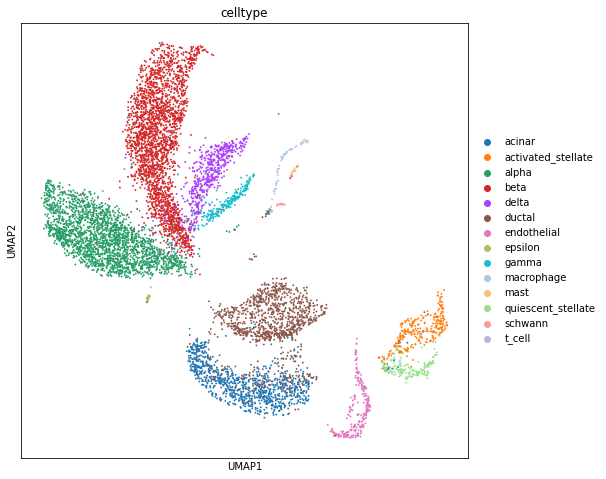

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Segerstolpe


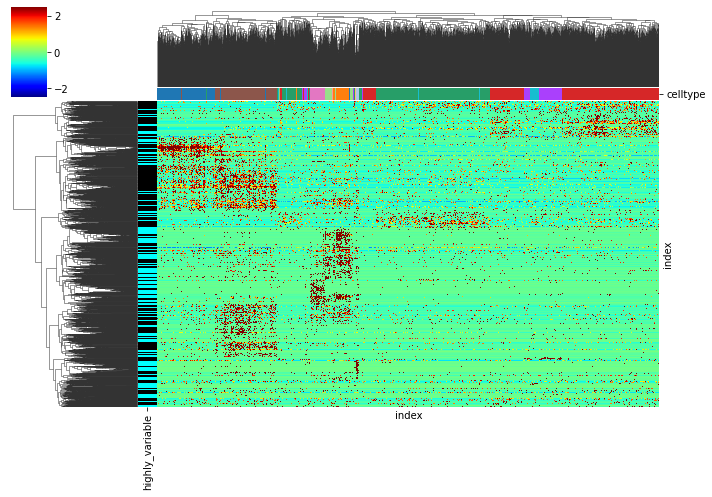

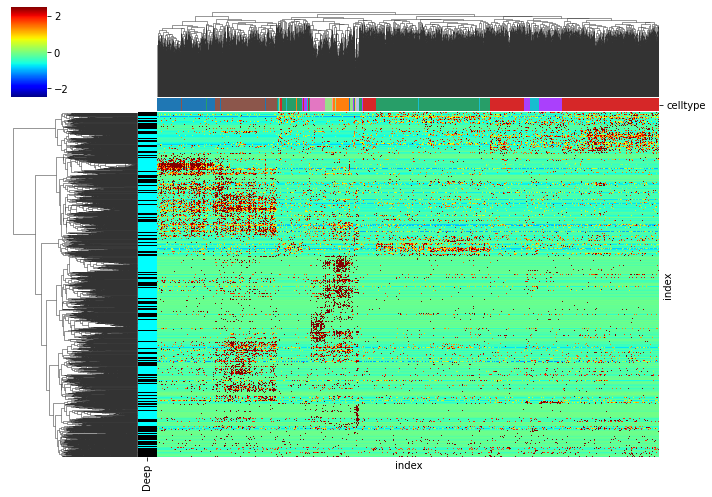

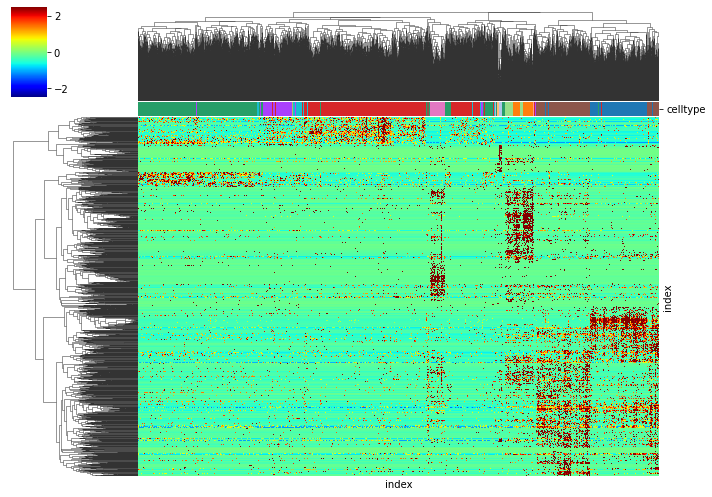

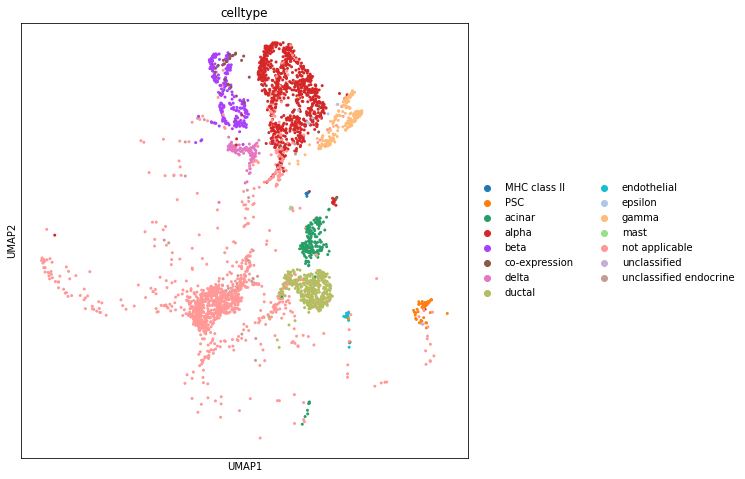

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Muraro


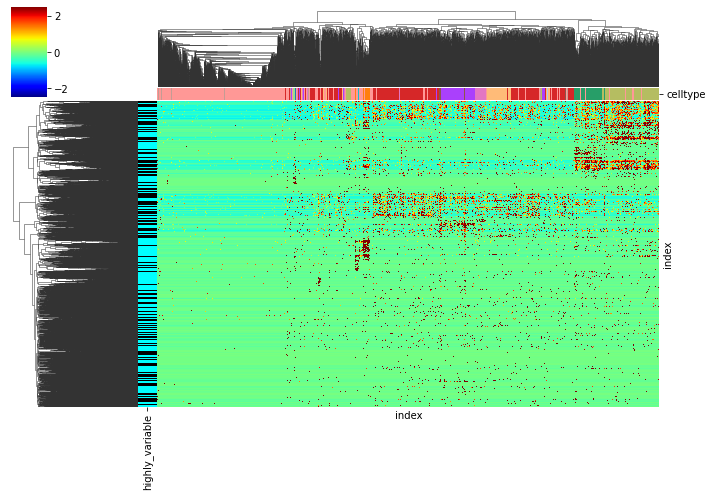

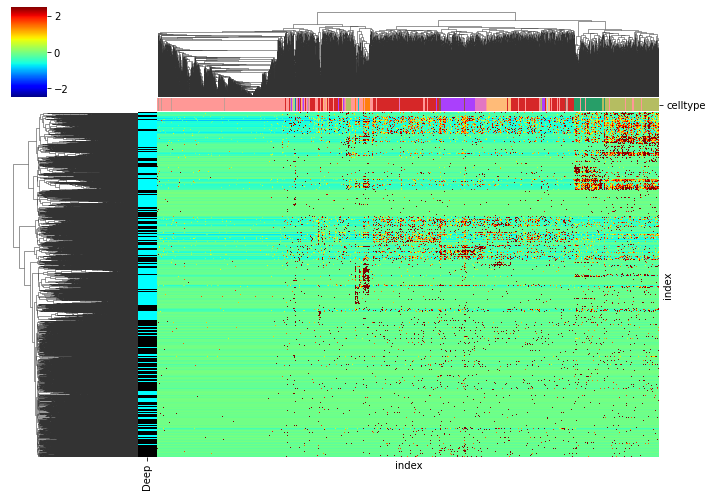

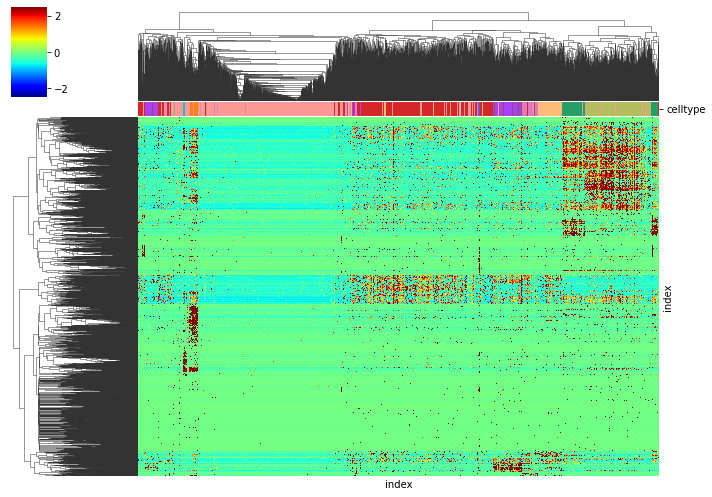

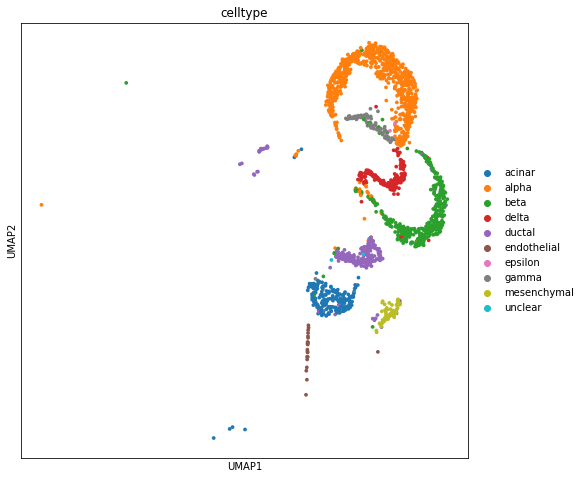

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


Wang


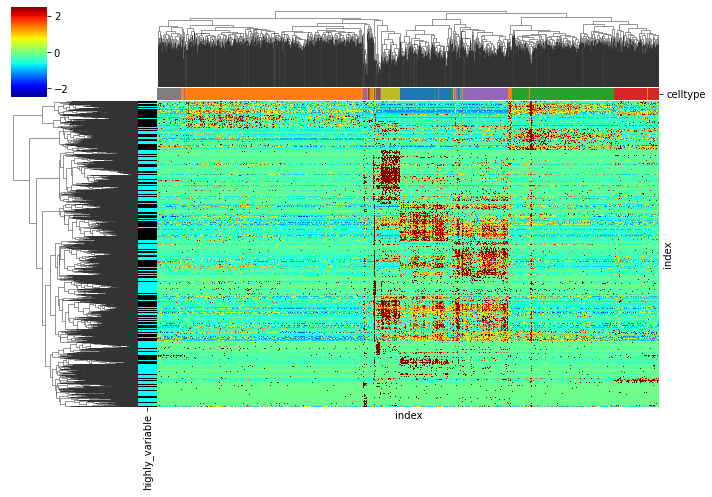

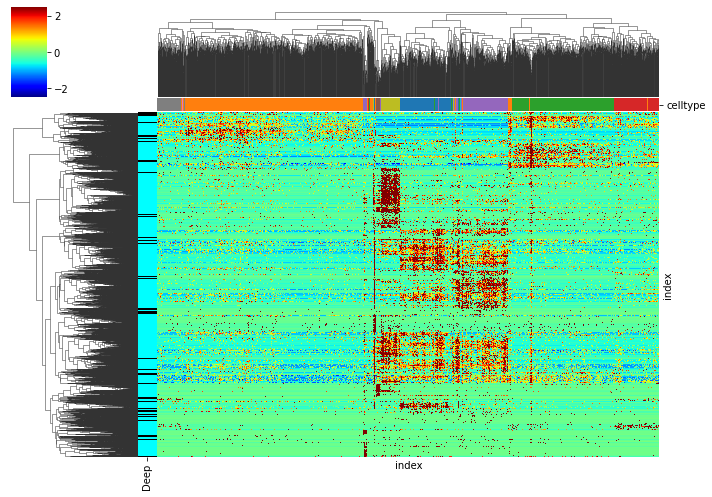

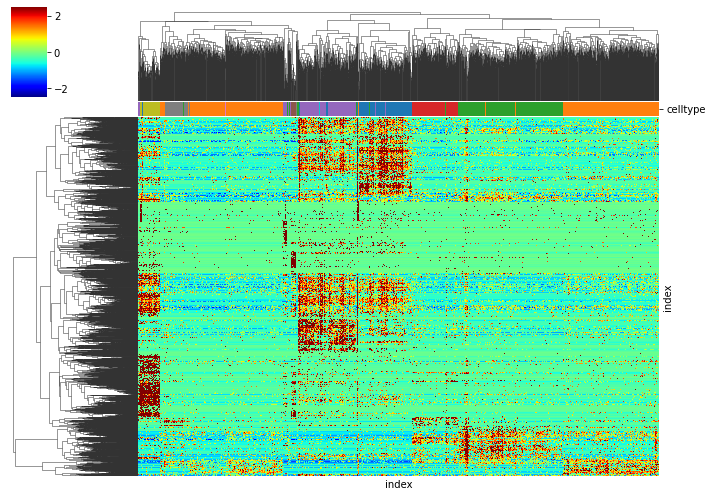

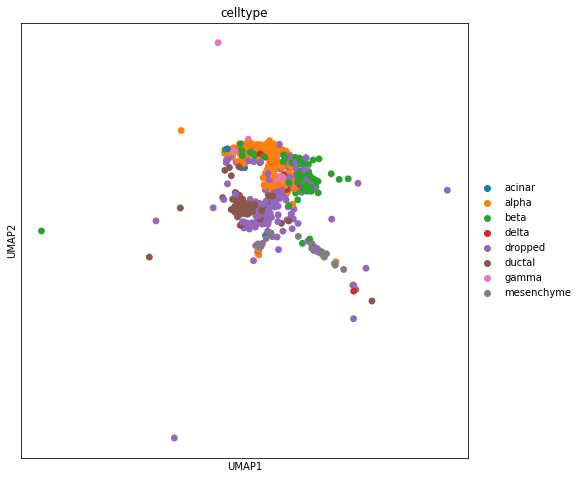

Trying to set attribute `.var` of view, copying.


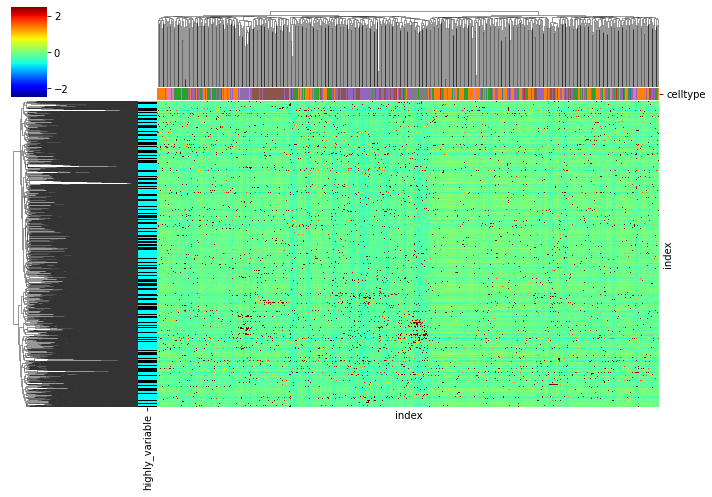

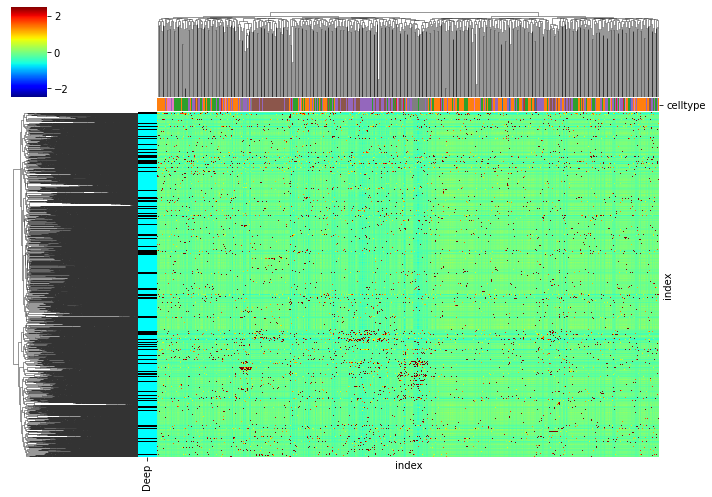

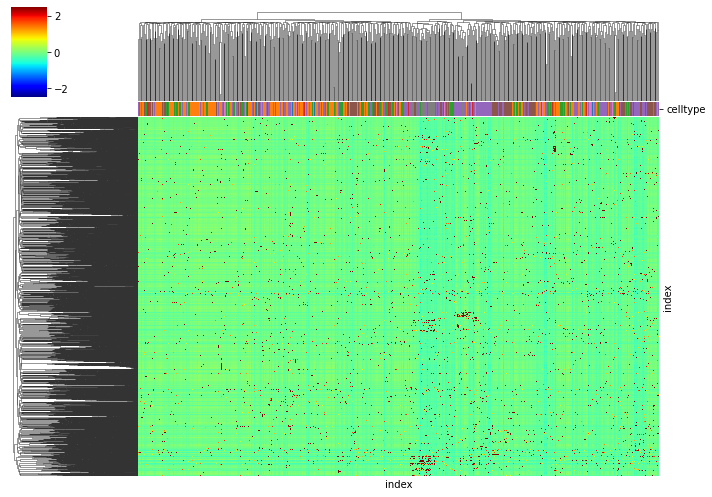

In [8]:
adata=Scanpyplus.DeepTree_per_batch(adata,batch_key='sample',obslist=['celltype'])

The function above isolates cells from each batch and calculate the most correlated highly variable genes in each batch. 

Three heatmaps were shown for the cells in each batch:
1. Batch HVG with global HVG marked in cyan
2. Batch HVG with batch DeepGene marked in cyan
3. Batch DeepGene (highly correlated batch HVG)

These are helpful for you to inspect each sample's quality as well

#### Check how many deep genes are shared across how many batches 

In [9]:
adata.var['Deep_n'].value_counts()

0    18756
1     3854
2     1271
3      589
4       46
Name: Deep_n, dtype: int64

From the stats, 1659 genes are deep genes unique to one single sample; 230 deep genes shared by exactly two samples... Considering that the union set has a reasonable number of genes for downstream analysis, we proceed with that.

##### Use a high-degree interset (at least "deep" in 3 batches here) as feature genes

In [10]:
adata.raw=adata
adata=adata[:,adata.var['Deep_n']>2] #You can choose ['Deep_n']>0 or 1
                                    #for larger gene set
                                    #which may loosen integration
adata.var['highly_variable']=True
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

Trying to set attribute `.var` of view, copying.


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


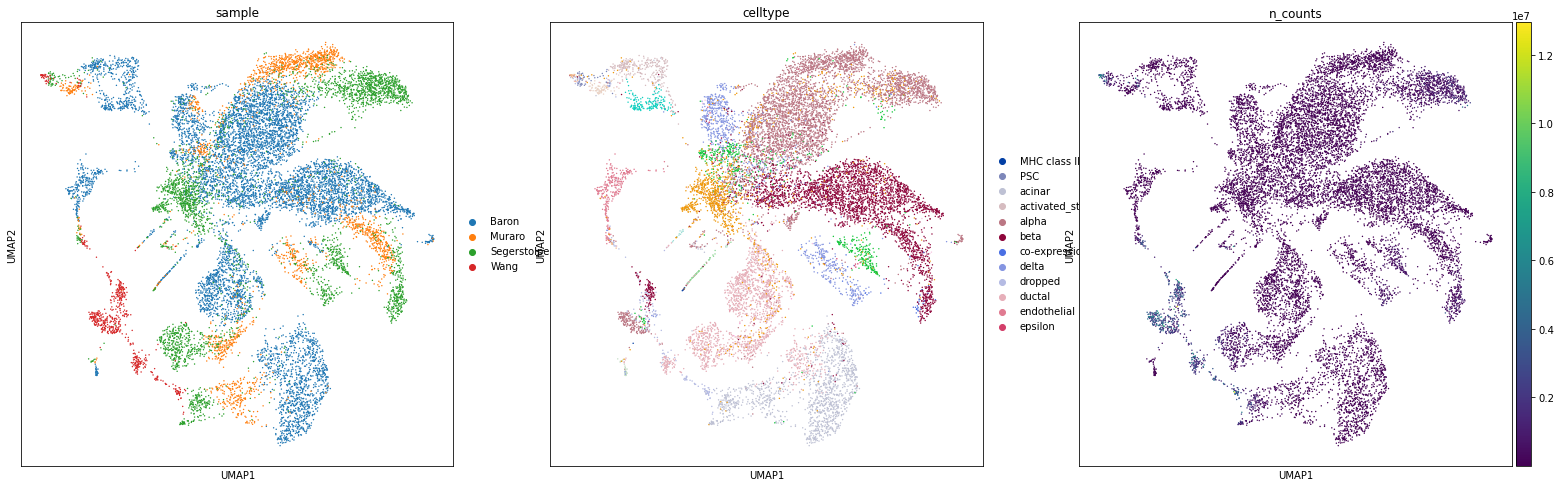

In [12]:
sc.pl.umap(adata,color=['sample','celltype','n_counts'])

As you can see, batch effect weakened. The sample sitting in the center may represent the one with lowest quality, which radiates towards high-quality cells.

This soft integration method works the best for batch effects weaker than this cross-platform case but stronger than the other cross-donor case of the limb data.